In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt, log, exp, isnan
import pandas as pd

#### Here we define fits and variables

In [5]:
dt = .001 # Time differential

t0 =  0  # intial time
tF = 60  # final time

nA = 3 # number of affinities

vNames = tuple(("B0", "d_BG", "K_B", "K_G", "K_M", "K_P", "d_G", "f_M", "h_B", "h_G", "lam", "lam_g", "m", "mu", "r_B", "r_G", "sigma_A", "sigma_N"))

# Contstants/fits from Mathematica,
# where K valaues were fit without r_G varying for affinities
# they all end with 2 just because
B02 = 71.5717
d_BG2 = 0.065535
K_B2 = 377545.83660675515  # these are the carrying capacities fit 
K_G2 = 2945436.919426182   # by fixing all other variables
K_M2 = 313187.04149637517  # they are high but seem good for data?
K_P2 = 1970627.5279410626
d_G2 = 0.179527
f_M2 = 7.04933
h_B2 = 0.000108336
h_G2 = 2.34565 * (10 ** -11)
lam2 = 5.37004
lam_g2 = 2.13042
m2 = 1.80624
mu2 = 1.2265 * (10 ** 7)
r_B2 = 6.16541
r_G2 = 0.262815

sigma_A2 = 0.135469;
sigma_N2 = 0.409708;

# the NLL of vInit with the fitted carrying caps came to +152
             # 0    1      2     3     4     5     6     7     8     9     10    11      12  13   14    15    16        17
vInit1 = tuple((B02, d_BG2, K_B2, K_G2, K_M2, K_P2, d_G2, f_M2, h_B2, h_G2, lam2, lam_g2, m2, mu2, r_B2, r_G2, sigma_A2, sigma_N2, ))

# best fit for non-varying, NLL of +23
v1 = tuple((71.57085367006788, 0.06463295641225468, 377545.8364483151, 2945436.9191686423, 313187.04126673046, 1970627.5279639903, 0.18021990590374032, 7.049168198836959, 9.653130801557743e-05, 5.962327580219918e-12, 5.3730461869275015, 2.139310246356731, 1.8068232723301068, 12265000.0, 6.159892717210376, 0.21337553327932302, 0.137237976009549, 0.41438129911454397))

# K values fit fixing mathematica constants where r_G varies for affinities
# with r_G_k = r_G * sqrt(nA - k + 1)
# got NLL of +168
vInit2 = tuple((71.5717, 0.065535, 328726.6062377675, 5341823.81009523, 580331.2561396586, 2755753.060332675, 0.179527, 7.04933, 0.000108336, 2.3456499999999998e-11, 5.37004, 2.13042, 1.80624, 12265000.0, 6.16541, 0.262815, 0.135469, 0.409708))

# best fit for varying down, NLL of +29
v2 = tuple((71.5707029057584, 0.06437584310008822, 328726.6060622158, 5341823.809875354, 580331.2559097223, 2755753.060365611, 0.18036213023360353, 7.049110679674612, 9.490951582071007e-05, 4.829485339978134e-12, 5.373575720273703, 2.141041252835504, 1.806926514482076, 12265000.0, 6.1589209137089505, 0.211027031632532, 0.13755057413637264, 0.4153910609440449))

# And of course, K values fit fixing Mathematica constants,
# where r_G_k = r_G * sqrt(k)
# got NLL of 129
vInit3 = tuple((71.5717, 0.065535, 482148.3774272156, 2443358.0884611337, 304991.23421262554, 2268794.354938257, 0.179527, 7.04933, 0.000108336, 2.3456499999999998e-11, 5.37004, 2.13042, 1.80624, 12265000.0, 6.16541, 0.262815, 0.135469, 0.409708))

# best fit for varying up, NLL of -31
v3 = tuple((71.57109652367608, 0.0650101260655951, 356028.1491529613, 775699.7636703714, 74131.23401836159, 2309371.45876738, 0.18000465775416777, 7.049252092219292, 0.00010007161136814103, 9.087528700228498e-12, 5.372240034911989, 2.1369008045565527, 1.8066628340484971, 12265000.0, 6.161365601362617, 0.21331835311053862, 0.13668613156010845, 0.4126199150522979))

# because v3 fits the best, the model below utilizes r_G_k = r_G * sqrt(k)
# if you'd like to view the other ways, you should change it in eqns 4 - 7

# Intial conditions
A0 = 1
A_g0 = 0

# the number of steps
N = int(round((tF-t0)/dt))

Aarr = np.zeros(N + 1)
Aarr[0] = A0
A_garr = np.zeros(N + 1)
A_garr[0] = A_g0
Barr = np.zeros(N + 1)
Barr[0] = vInit1[0]

Garr = np.zeros((4, N + 1))
Marr = np.zeros((4, N + 1))
Parr = np.zeros((4, N + 1))

Gtotarr = np.zeros(N + 1)
Mtotarr = np.zeros(N + 1)
Ptotarr = np.zeros(N + 1)

tarr = np.zeros(N + 1)
tarr[0] = t0


#### Here we set up the arrrays for approximating the model

In [6]:
def reInitArrs(B0):
    global Aarr, A_garr, Barr, Garr, Marr, Parr, Gtotarr, Mtotarr, Ptotarr, tarr
    
    Aarr = np.zeros(N + 1)
    Aarr[0] = A0
    A_garr = np.zeros(N + 1)
    A_garr[0] = A_g0
    Barr = np.zeros(N + 1)
    Barr[0] = B0

    Garr = np.zeros((4, N + 1))
    Marr = np.zeros((4, N + 1))
    Parr = np.zeros((4, N + 1))

    Gtotarr = np.zeros(N + 1)
    Mtotarr = np.zeros(N + 1)
    Ptotarr = np.zeros(N + 1)

    tarr = np.zeros(N + 1)
    tarr[0] = t0


#### Here we have all the equations for the affinity model as laid out in the writeup

In [7]:
#Eqn 1
def dAdt(lam, m, A):
    return (-1 * (lam + m) * A)

#Eqn 2
def dA_gdt(lam_g, m, A, A_g):
    return m * A - lam_g * A_g

#Eqn 3
def dBdt(r_B, h_B, K_B, d_BG, A, B):
    return r_B * A / (h_B + A) * B - (d_BG * B) - (r_B * B * B / K_B)

#Eqn 4 and 5
# k is the index on G
#G[k]'[t] == If[k == 1, 1, 0] * dBG * B[t] + (1 - muG / (1 + muG) * If[k == nA, 0, 1]) * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) * G[k][t] - (deltaG + dG * rG * Sqrt[k] * Ag[t] / (hG + Ag[t])) * G[k][t] + muG / (1 + muG) * 
           # If[k == 1, 0, 1] * rG * Sqrt[k - 1] * Ag[t] / (hG + Ag[t]) * G[k - 1][t], {k, 1, nA}],            
def dG_kdt(k, d_BG, d_G, h_G, K_G, mu, r_G, A_g, B, G_k, G_kmin1, G_tot):
    if(k == 1): c0 = 1
    else: c0 = 0
        
    # modifiy n here
    if(k == nA): c1 = 0
    else: c1 = 1
        
    if(k == 1): c2 = 0
    else: c2 = 1
    ###    New GC B cells that are coming from plasmaplastsi                                          GC B cells that differentiate into M/P
    return c0 * d_BG * B + (1 - mu / (1 + mu) * c1) * r_G * sqrt(k) * A_g / (h_G + A_g) * G_k - (d_G * r_G * sqrt(k) * A_g / (h_G + A_g)) * G_k + mu / (1 + mu) * c2 * r_G * sqrt(k-1) * A_g / (h_G + A_g) * G_kmin1 - (r_G * sqrt(k) * G_tot * G_tot / K_G)
    
#Eqn 6
# fM * Exp[-aM * (k - 1)] / (1 + fM * Exp[-aM * (k - 1)]) * dG *G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaM * M[k][t],
def dM_kdt(k, f_M, d_G, r_G, h_G, K_M, A_g, G_k, M_k, M_tot):
    a_M = .5 # ???? or is it fit?
    return f_M * exp(-1 * a_M * (k - 1)) / (1 + f_M * exp(-1 * a_M * (k - 1))) * d_G * G_k * r_G * sqrt(k) * A_g / (h_G + A_g) - (r_G * sqrt(k) * M_tot * M_tot / K_M)

#Eqn 7
#Table[P[k]'[t] == (1 / (1 + fM * Exp[-aM * (k - 1)])) * dG * G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaP * P[k][t], {k, 1, nA}]
def dP_kdt(k, f_M, d_G, r_G, h_G, K_P, A_g, G_k, P_k, P_tot):
    a_M = .5 
    return (1 / (1 + f_M * exp(-a_M * (k - 1)) ) ) * d_G * G_k * r_G * sqrt(k) * A_g / (h_G + A_g) - (r_G * sqrt(k) * P_tot * P_tot / K_P)


#### The main function of the model. 
It utilizes the Euler method for approximating systems of differential equations:
https://en.wikipedia.org/wiki/Euler_method
There may be limitations (esp w/ small time steps) when using this method

In [8]:
# Euler method
def euler(v):
    global Aarr, A_garr, Barr, tarr, Garr, Parr, Marr, Gtotarr, Mtotarr, Ptotarr
    
    (B0, d_BG, K_B, K_G, K_M, K_P, d_G, f_M, h_B, h_G, lam, lam_g, m, mu, r_B, r_G, sigma_A, sigma_N) = v
    reInitArrs(B0)
    
    for i in range(1, N + 1):
        #f_M = .5
        A = Aarr[i - 1]
        A_g = A_garr[i - 1]
        B = Barr[i - 1]
        t = tarr[i - 1]
        Aarr[i] = A + dt * dAdt(lam, m, A)
        A_garr[i] = A_g + dt * dA_gdt(lam_g, m, A, A_g)
        Barr[i] = B + dt * dBdt(r_B, h_B, K_B, d_BG, A, B)
        
        G_tot = Gtotarr[i - 1]
        P_tot = Ptotarr[i - 1]
        M_tot = Mtotarr[i - 1]
        for k in range(1, 4):
            G_k = Garr[k, i - 1]
            G_kmin1 = Garr[k - 1, i - 1]
            P_k = Parr[k, i - 1]
            M_k = Marr[k, i - 1]
            Garr[k, i] = G_k + dt * dG_kdt(k, d_BG, d_G, h_G, K_G, mu, r_G, A_g, B, G_k, G_kmin1, G_tot)
            Marr[k, i] = M_k + dt * dM_kdt(k, f_M, d_G, r_G, h_G, K_M, A_g, G_k, M_k, M_tot)
            Parr[k, i] = P_k + dt * dP_kdt(k, f_M, d_G, r_G, h_G, K_P, A_g, G_k, P_k, P_tot)

            Gtotarr[i] += Garr[k, i]
            Ptotarr[i] += Parr[k, i]
            Mtotarr[i] += Marr[k, i]
            
    
        tarr[i] = t + dt
    
    for i in range(1, len(Barr)):
        Barr[i]+= B0

#### Here, we extract expiremental data from csv's to plot w/ model

In [9]:
# Cell counts for  PBs GCBs and MCs
csv = pd.read_csv('data-Bcell-dynamics-edited-permouse.csv', index_col = 'day', names=['day','PB','GC','MC'])
Stimes = csv.index.values[1:-1].astype('int')
Spb = csv.PB.values[1:-1].astype('double')
Sgc = csv.GC.values[1:-1].astype('double')
Smc = csv.MC.values[1:-1].astype('double')

# Cell counts for PC's
xlsx = pd.read_excel('LLPC_total_numbers.xlsx', index_col = 'day', names =['day','zero','one','two','three'])
Stimes2 = xlsx.index.values[0:4].astype('int')
Stimes2 = np.repeat(Stimes2, 4)
Spc = np.zeros(16)
for i in range (0, 4):
    Spc[4*i + 0] = xlsx.zero.values[i].astype('double')
    Spc[4*i + 1] = xlsx.one.values[i].astype('double')
    Spc[4*i + 2] = xlsx.two.values[i].astype('double')
    Spc[4*i + 3] = xlsx.three.values[i].astype('double')

# Cell affinities
csv2 = pd.read_csv('data-IgHg2A10_affinity-cleaned.csv', index_col = 'day', names = ['day', 'AA', 'celltype', 'mouse'])
csv2.sort_values(by = 'day')
Sapbt, Sagct, Samct, Sapct = [], [], [], []
Sapb, Sagc, Samc, Sapc = [], [], [], []

for i in range(len(csv2.index)):
    if(csv2.celltype.values[i] == "PB"):
        Sapbt.append(int(csv2.index.values[i]))
        Sapb.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "GC"):
        Sagct.append(int(csv2.index.values[i]))
        Sagc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "MC" or csv2.celltype.values[i] == "MBC"):
        Samct.append(int(csv2.index.values[i]))
        Samc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "PC"):
        Sapct.append(int(csv2.index.values[i]))
        Sapc.append(float(csv2.AA.values[i]))

In [10]:
def calcAA():
    global Garr, Gtotarr, Marr, Mtotarr, Parr, Ptotarr, Barr
    
    BAarr, GAarr, MAarr, PAarr = np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1))
    avgPBA = 0
    k = 0
    for i in Sapb:
        if(math.isnan(i)):
            continue
        avgPBA += i
        k += 1
    avgPBA = avgPBA / k
    
    for i in range(N+1):
        
        avgG, avgM, avgP = 0, 0, 0
        for j in range(1, 4):
            avgG += Garr[j, i] * j
            avgM += Marr[j, i] * j
            avgP += Parr[j, i] * j
            
        totG = Gtotarr[i]
        totM = Mtotarr[i]
        totP = Ptotarr[i]
        if(totG == 0): totG = 1
        if(totM == 0): totM = 1
        if(totP == 0): totP = 1
        avgG = avgG/totG
        avgM = avgM/totM
        avgP = avgP/totP 
    
        BAarr[i] = avgPBA 
        GAarr[i] = avgG
        MAarr[i] = avgM
        PAarr[i] = avgP
        
    return [BAarr, GAarr, MAarr, PAarr]


In [12]:
def NLL(v):
    
    euler(v)
    
    # Scatter number, model number of cells
    snt = [Stimes, Stimes, Stimes, Stimes2]
    sn = [Spb, Sgc, Smc, Spc]
    mn = [Barr, Gtotarr, Mtotarr, Ptotarr]
    
    sat = [Sapbt, Sagct, Samct, Sapct]
    sa = [Sapb, Sagc, Samc, Sapc]
    ma = calcAA()
    
    sum1 = 0
    n1 = 0
    for j in range(4):
        k = 0
        for i in snt[j]:
            actual = sn[j][k]
            predicted = mn[j][int(i/dt)]
            k += 1
            if(actual <= 0 or predicted <= 0 or math.isnan(actual)): continue
            n1 += 1
            sum1 += ( (math.log(actual, 10) - math.log(predicted, 10)) ** 2 ) / (2 * (v[17] ** 2))
            #print(j, i, actual, predicted, sum1)
    
    sum2 = 0       
    n2 = 0
    for j in range(4):
        k = 0
        for i in sat[j]:
            actual = sa[j][k]
            predicted = ma[j][int(i/dt)]
            k += 1
            if(math.isnan(actual)): continue
            n2 += 1
            sum2 += ((actual- predicted) ** 2) / (2 * (v[16] ** 2))
            #print(j, i, actual, predicted, sum2)
        
    #n1 = len(Stimes)
    #n2 = len(Sapbt) # This does make it so that we are using n1/n2 unrelated to what we have summed over
    
    
    #print(sum1)
    #print(sum2)
        
    # Also, the base for logs just changes here for no reason????
    return (sum1 + sum2 + (n1 * math.log(v[17])) + (n2 * math.log(v[16])))


#### Here, we run the model and graph the results

(71.57109652367608, 0.0650101260655951, 356028.1491529613, 775699.7636703714, 74131.23401836159, 2309371.45876738, 0.18000465775416777, 7.049252092219292, 0.00010007161136814103, 9.087528700228498e-12, 5.372240034911989, 2.1369008045565527, 1.8066628340484971, 12265000.0, 6.161365601362617, 0.21331835311053862, 0.13668613156010845, 0.4126199150522979)
-31.013196791259645


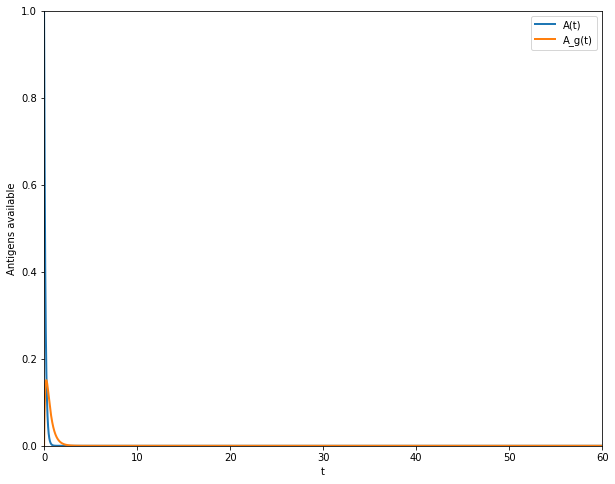

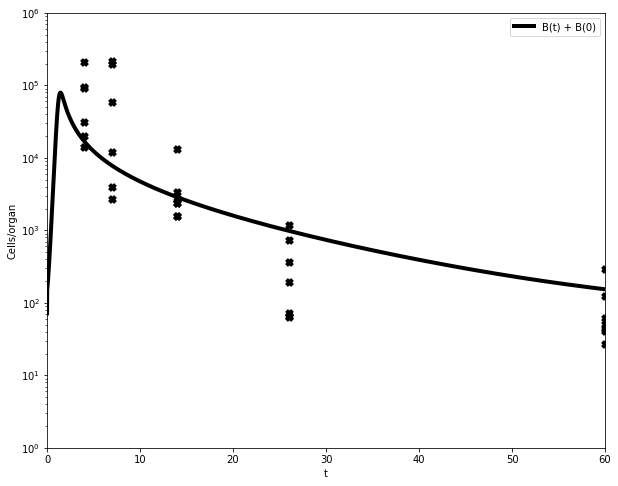

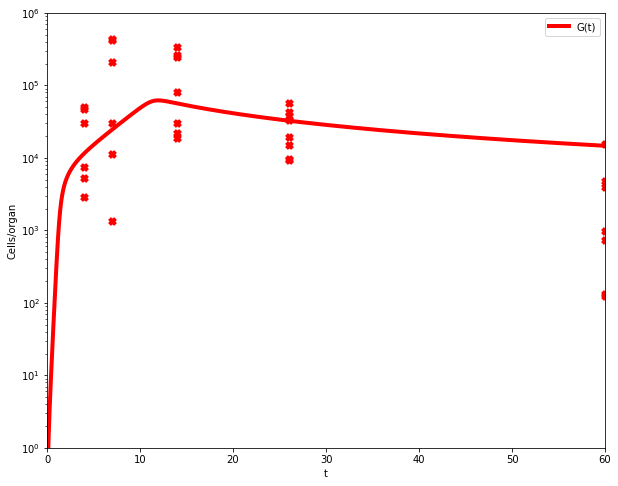

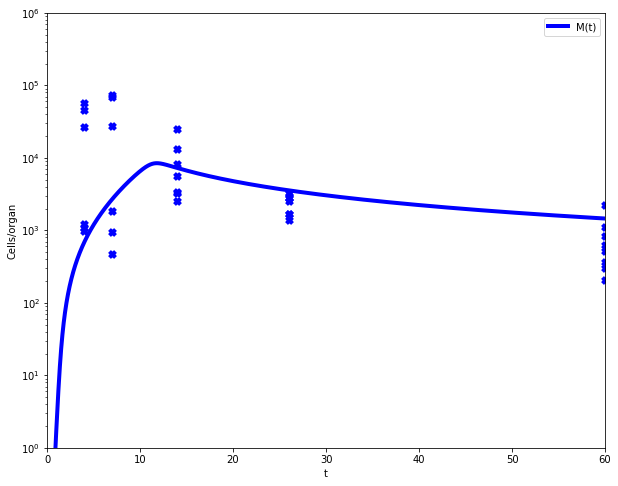

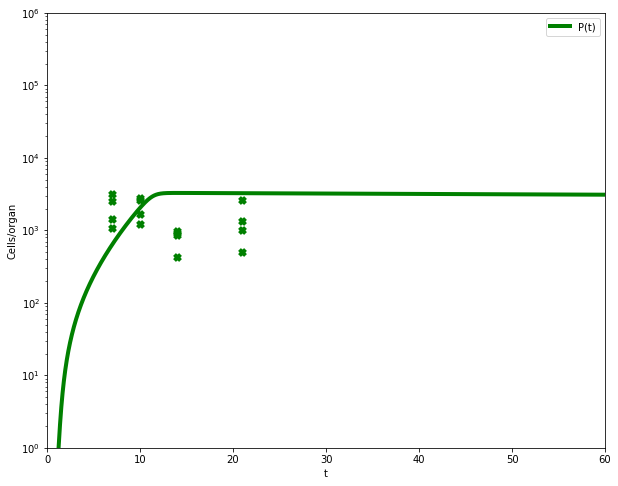

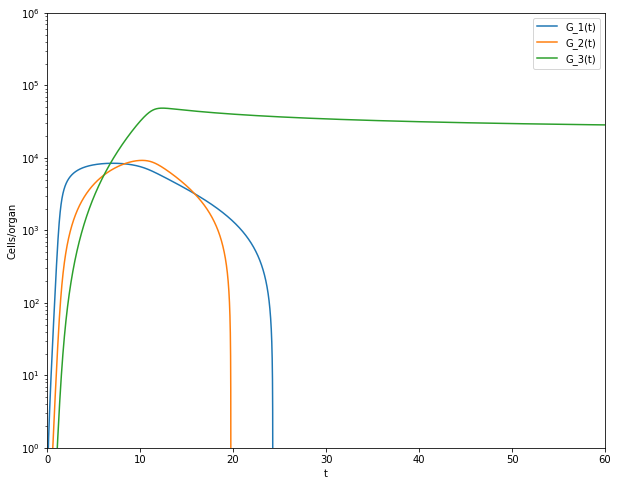

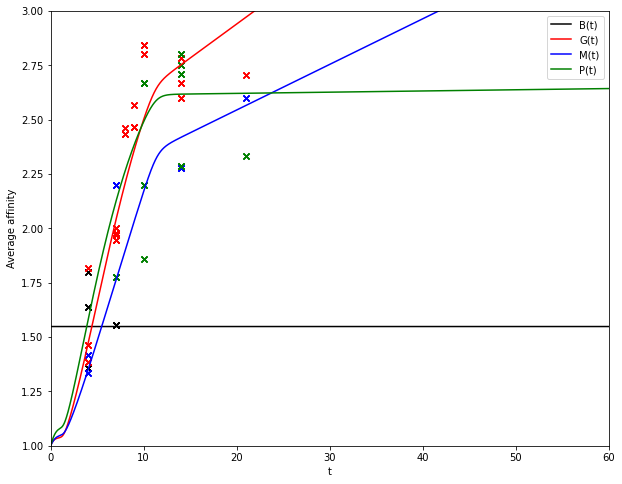

In [33]:
# Call the function to run the model so we can graph
print(v)
print(NLL(v))

# Graph of antigens available
fig1 = plt.figure()
fig1.set_size_inches(10,8)

plt.plot(tarr, Aarr, label = "A(t)", linewidth = 2)
plt.plot(tarr, A_garr, label = "A_g(t)", linewidth = 2)

plt.xlabel("t")
plt.ylabel("Antigens available")

plt.axis([t0, tF, 0, 1])

plt.legend()
plt.show()

#Plasmablasts graph

fig2 = plt.figure()
fig2.set_size_inches(10,8)

plt.plot(tarr, Barr, linewidth = 4, label = "B(t) + B(0)", color = 'black')
plt.scatter(Stimes, Spb, linewidth = 4, marker = 'x', color = 'black')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# GC B cells graph

fig3 = plt.figure()
fig3.set_size_inches(10,8)

plt.plot(tarr, Gtotarr, linewidth = 4, label = "G(t)", color = 'red')
plt.scatter(Stimes, Sgc, linewidth = 4, marker = 'x', color = 'red')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# MCB cells graph

fig4 = plt.figure()
fig4.set_size_inches(10,8)

plt.plot(tarr, Mtotarr, linewidth = 4, label = "M(t)", color = 'blue')
plt.scatter(Stimes, Smc, linewidth = 4, marker = 'x', color = 'blue')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Plasma cells graph

fig5 = plt.figure()
fig5.set_size_inches(10,8)

plt.plot(tarr, Ptotarr, linewidth = 4, label = "P(t)", color = 'green')
plt.scatter(Stimes2, Spc, linewidth = 4, marker = 'x', color = 'green')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Graph of GC B cell affinities 

fig6 = plt.figure()
fig6.set_size_inches(10,8)


plt.plot(tarr, Garr[1], label = "G_1(t)")
plt.plot(tarr, Garr[2], label = "G_2(t)")
plt.plot(tarr, Garr[3], label = "G_3(t)")
plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show

# Average affinities
fig7 = plt.figure()
fig7.set_size_inches(10,8)

plt.plot(tarr, calcAA()[0], label = "B(t)", color = 'black')
plt.scatter(Sapbt, Sapb, marker = 'x', color = 'black')
plt.plot(tarr, calcAA()[1], label = "G(t)", color = 'red')
plt.scatter(Sagct, Sagc, marker = 'x', color = 'red')
plt.plot(tarr, calcAA()[2], label = "M(t)", color = 'blue')
plt.scatter(Samct, Samc, marker = 'x', color = 'blue')
plt.plot(tarr, calcAA()[3], label = "P(t)", color = 'green')
plt.scatter(Sapct, Sapc, marker = 'x', color = 'green')


plt.xlabel("t")
plt.ylabel("Average affinity")
plt.axis([t0, tF, 1.0, 3.0])

plt.legend()
plt.show()

#### Here, we start fitting variables to the data using gradient descent

It is currently set to use SSR for this. This does not seem to be a good function to use for fitting the graph, as fits with less SSR don't look as good as the init fit.

In [30]:
learningRate = .1

def grad(v):
    nll1 = NLL(v)
    
    nlllist.append(nll1)
    print(nll1)
    
    grad = tuple(())
    
    for i in range(0, len(v)):
        # change this to restrict what we fix
        if(vNames[i] not in vNames):
            grad += tuple((0.0,))
            continue
            
        dV = .1
        v2 = v[0:i] + tuple((v[i] + dV, )) + v[i+1:]
        dnll = NLL(v2) - nll1
        
        print('  dV of ', dV, ' on ', vNames[i], ' got nll of', dnll + nll1, ' for a dnll ', dnll)
        
        grad += tuple((dnll/dV, ))
    
    print('  grad =', grad)
    
    return grad
    
def deltaV(grad, v):
    gMax = max(np.absolute(grad))
    gMin = min(np.absolute(grad))
        
    deltaV = tuple(())
    for i in range(0, len(v)):
        if (grad[i] == 0.0): deltaV += tuple((0.0,))
        else: deltaV += tuple(((-1 * (grad[i]/abs(grad[i])) * (abs(grad[i]/gMax)) * v[i] * learningRate),))
    
    return deltaV
        
              
def gradDescent(v):
    strikes = 0 # just like baseball, if it misses 3 times we stop
    for i in range (1, 100):
        nllOld = NLL(v)
        
        print(i)
        print('v = ', v)
        
        dV = deltaV(grad(v), v)
        print('dV = ', dV)
        
        newV = tuple(())
        
        for j in range(0, len(v)):
            newV += tuple((v[j] + dV[j], ))
        
        nllNew = NLL(newV)
        
        if(nllNew > nllOld): 
            if(strikes == 0): goodV = v
            strikes += 1
            if(strikes >= 2):
                return goodV
            
        else: 
            strikes = 0
        
        v = newV
            
    return v

nlllist = list((NLL(v),))
v = gradDescent(v)

print(nlllist)

1
v =  (71.57109652367608, 0.0650101260655951, 356028.1491529613, 775699.7636703714, 74131.23401836159, 2309371.45876738, 0.18000465775416777, 7.049252092219292, 0.00010007161136814103, 9.087528700228498e-12, 5.372240034911989, 2.1369008045565527, 1.8066628340484971, 12265000.0, 6.161365601362617, 0.21331835311053862, 0.13668613156010845, 0.4126199150522979)
-31.013196791259645
  dV of  1e-07  on  h_G  got nll of 664.3049913107045  for a dnll  695.3181881019641
  grad = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6953181881.019641, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
dV =  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.087528700228499e-19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
2
v =  (71.57109652367608, 0.0650101260655951, 356028.1491529613, 775699.7636703714, 74131.23401836159, 2309371.45876738, 0.18000465775416777, 7.049252092219292, 0.00010007161136814103, 9.087527791475628e-12, 5.372240034911989, 2.1369008045565527, 1.8066628340484971, 12265000.0, 6.161365601362617, 0.213

## 

#### Here, we define a sum of square residuals function to evaluate each model

In [11]:
def SSR(scatterTimes, scatterVals, valArr):
    j = 0
    ssr = 0.0
    for i in scatterTimes:
        actual = scatterVals[j]
        pred = valArr[int(i / dt)]
        sr = (actual - pred) * (actual - pred)
        ssr += sr
        #print(i, j, actual, pred, sr, ssr)
        j += 1
        
    return ssr

# 

In [12]:
def SSRAll(v):
    global Stimes, Spb, tarr, Barr, Sgc, Gtotarr, Smc, Mtotarr, Stimes2, Spc, Ptotarr
    euler(v)
    ssrAll = 0.0
    ssrAll = SSR(Stimes, Spb, Barr)
    ssrAll += SSR(Stimes, Sgc, Gtotarr)
    ssrAll += SSR(Stimes, Smc, Mtotarr)
    ssrAll += SSR(Stimes2, Spc, Ptotarr)
    
    return ssrAll